In [1]:
import pandas as pd
from geopy.geocoders import Nominatim
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon
import numpy as np

In [2]:
import plotly.express as px
from dash import Dash, html, dcc
from dash.dependencies import Input, Output
import wordcloud

In [3]:
#load data
aed_locations = pd.read_parquet('Data/aed_locations.parquet.gzip', engine='pyarrow')
ambulance_locations = pd.read_parquet('Data/ambulance_locations.parquet.gzip', engine='pyarrow')
cad9 = pd.read_parquet('Data/cad9.parquet.gzip', engine='pyarrow')

interventions1 = pd.read_parquet('Data/interventions1.parquet', engine='pyarrow')
interventions2 = pd.read_parquet('Data/interventions2.parquet', engine='pyarrow')
interventions3 = pd.read_parquet('Data/interventions3.parquet', engine='pyarrow')

interventions_bxl = pd.read_parquet('Data/interventions_bxl.parquet.gzip', engine='pyarrow')
interventions_bxl2 = pd.read_parquet('Data/interventions_bxl2.parquet.gzip', engine='pyarrow')

mug_locations = pd.read_parquet('Data/mug_locations.parquet.gzip', engine='pyarrow')
pit_locations = pd.read_parquet('Data/pit_locations.parquet.gzip', engine='pyarrow')

#### data exploration

##### ambulance - source

In [4]:
#data exploration
ambulance_locations.info()
ambulance_locations.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279 entries, 0 to 278
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   base                       279 non-null    object 
 1   medical_resource           279 non-null    object 
 2   province                   266 non-null    object 
 3   region                     279 non-null    object 
 4   departure_location         279 non-null    object 
 5   departure_location_number  279 non-null    int64  
 6   latitude                   279 non-null    float64
 7   longitude                  279 non-null    float64
 8   occasional_permanence      279 non-null    object 
dtypes: float64(2), int64(1), object(6)
memory usage: 19.7+ KB


,base,medical_resource,province,region,departure_location,departure_location_number,latitude,longitude,occasional_permanence
0,BA ANTW [Borgerhout] AMBUCE,ZW ANTWERPEN 7 (Team: AAANTW07A),Antwerpen,Vlaams Gewest,Gijselstraat 150 2140 BORGERHOUT,3811,51.215516,4.443788,N
1,BA ANTW [Hoboken] AMBUCE,ZW ANTWERPEN 9 (Team: AAANTW09A),Antwerpen,Vlaams Gewest,Antwerpsesteenweg 242 2660 HOBOKEN,3812,51.178831,4.361948,N
2,BA ANTW [Hof Ter Schelde] AC Antwerpen,ZW ANTWERPEN 3 (Team: AAANTW03A),Antwerpen,Vlaams Gewest,August Vermeylenlaan 6 2050 ANTWERPEN,10902,51.232810,4.377237,N
3,BA ANTW [Kaai 606] SIHWA,ZW ANTWERPEN HAVEN 1 (Team: AAAPOR01A)_x000D_Z...,Antwerpen,Vlaams Gewest,Antwerpsebaan 4 (Kaai 606) 2040 ANTWERPEN,12902,51.315516,4.321506,N
4,BA ANTW [Sint Elisabeth] AC Antwerpen,ZW ANTWERPEN 2 (Team: AAANTW02A),Antwerpen,Vlaams Gewest,Leopoldstraat 26 2000 ANTWERPEN,10901,51.213623,4.405718,N


##### aed - source

AED (Automated External Defibrillators):  portable electronic devices that automatically diagnose life-threatening cardiac arrhythmias and treat them through defibrillation, allowing the heart to reestablish an effective rhythm.

In [5]:
aed_locations.info()
aed_locations.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15227 entries, 0 to 15226
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            15225 non-null  float64
 1   type          5167 non-null   object 
 2   address       15225 non-null  object 
 3   number        13085 non-null  float64
 4   postal_code   15193 non-null  float64
 5   municipality  15142 non-null  object 
 6   province      15190 non-null  object 
 7   location      8423 non-null   object 
 8   public        8079 non-null   object 
 9   available     4290 non-null   object 
 10  hours         1077 non-null   object 
dtypes: float64(3), object(8)
memory usage: 1.3+ MB


,id,type,address,number,postal_code,municipality,province,location,public,available,hours
0,13.0,None,Blvd. Fr. Roosevelt,24.0,7060.0,SOIGNIES,Hainaut,None,Y,None,None
1,70.0,None,Ch. De Wégimont,76.0,4630.0,Ayeneux,Liège,None,None,None,None
2,71.0,None,Place Saint - Lambert,NaN,4020.0,Liège,Liège,None,None,None,None
3,72.0,None,Rue du Doyard,NaN,4990.0,Lierneux,Liège,None,None,None,None
4,73.0,None,Fond Saint Servais,NaN,4000.0,Liège,Liège,None,None,None,None


##### cad9 - call center

CAD9 (Computer-Aided Dispatch): Systems used by emergency services that provide automated assistance to dispatchers, helping to manage calls for service and resources more efficiently.

In [6]:
cad9.info()
cad9.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289401 entries, 0 to 289400
Data columns (total 35 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   province                         289401 non-null  object 
 1   Mission ID                       289401 non-null  int64  
 2   Service Name                     196821 non-null  object 
 3   Latitude permanence              233726 non-null  float64
 4   Longitude permanence             233726 non-null  float64
 5   Permanence short name            289204 non-null  object 
 6   Permanence long name             196821 non-null  object 
 7   Vector Type                      289401 non-null  object 
 8   EventType Trip                   289343 non-null  object 
 9   EventSubType Trip                289401 non-null  object 
 10  EventLevel Trip                  289331 non-null  object 
 11  CityName intervention            289277 non-null  object 
 12  Ci

,province,Mission ID,Service Name,Latitude permanence,Longitude permanence,Permanence short name,Permanence long name,Vector Type,EventType Trip,EventSubType Trip,...,Name destination hospital,Intervention time (T1Reported),Intervention time (T1Confirmed),Departure time (T1Reported),Departure time (T1Confirmed),UI,ID,MISSION_NR,AMBUCODE,UNIT_ID
0,VBR,21221520003,MV HVP VILV West,50.925277,4.423057,AVVILV01A,ZW VILVOORDE 1,Ambulance,P034 - SCHEDELTRAUMA,/,...,HV UR VILV AZ JAN PORTAELS,10.0,NaN,2.0,NaN,21221520003 1969661672,19189868,21221520003,240.0,MVVILV101
1,VBR,21221520004,MV HVP HALL West,50.743200,4.241053,AVHALL02A,ZW HALLE 2,Ambulance,P010 - ADEMHALINGSMOEILIJKHEDEN,/,...,HV UR HALL AZ ST MARIA,7.0,NaN,3.0,NaN,21221520004 1969661709,19189847,21221520004,240.0,MVHALL102
2,VBR,21221520007,MV HVP VILV West,50.925277,4.423057,AVVILV01A,ZW VILVOORDE 1,Ambulance,Y_TI BEVRIJDING PERSOON BEKLEMD/OPGESLOTEN+DGH,/,...,HV UR VILV AZ JAN PORTAELS,10.0,NaN,4.0,NaN,21221520007 1969664866,19190011,21221520007,240.0,MVVILV101
3,VBR,21221520007,HV UR VILV AZ Jan Portaels,50.926869,4.420968,UVVILV01A,MUG VILVOORDE,MUG,Y_TI BEVRIJDING PERSOON BEKLEMD/OPGESLOTEN+DGH,/,...,HV UR VILV AZ JAN PORTAELS,7.0,NaN,1.0,NaN,21221520007 1969665019,19190053,21221520007,0.0,MVVILV301
4,VBR,21221520008,BB BRUX Hôpital Militair KA,50.905331,4.387662,ABBRUX13A,AMB HMB 13,Ambulance,P020 - INTOXICATIE ALCOHOL,/,...,None,14.0,NaN,7.0,NaN,21221520008 1969665449,19189967,21221520008,39.0,MBMILH101


##### interventions - call response

emergency medical services provided in response to calls for help, including the deployment of ambulances, AEDs, or other resources.

In [7]:
# Combine the datasets
interventions = pd.concat([interventions1, interventions2, interventions3], ignore_index=True)

In [8]:
interventions.info()
interventions.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 601881 entries, 0 to 601880
Data columns (total 46 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Mission ID                        601881 non-null  int64  
 1   Service Name                      601674 non-null  object 
 2   PostalCode permanence             599280 non-null  float64
 3   CityName permanence               599277 non-null  object 
 4   StreetName permanence             601671 non-null  object 
 5   HouseNumber permanence            35410 non-null   object 
 6   Latitude permanence               507600 non-null  float64
 7   Longitude permanence              587382 non-null  float64
 8   Permanence short name             601843 non-null  object 
 9   Permanence long name              601843 non-null  object 
 10  Vector type                       601881 non-null  object 
 11  EventType Firstcall               601865 non-null  o

,Mission ID,Service Name,PostalCode permanence,CityName permanence,StreetName permanence,HouseNumber permanence,Latitude permanence,Longitude permanence,Permanence short name,Permanence long name,...,Unavailable time,Name destination hospital,PostalCode destination hospital,CityName destination hospital,StreetName destination hospital,HouseNumber destination hospital,Calculated travelTime destinatio,Calculated Distance destination,Number of transported persons,Abandon reason
0,10221520001,HA UR MECH AZ St Maarten,2800.0,Mechelen (Mechelen),Liersesteenweg,None,51.051020,4.478030,AAMECH01A,ZW MECHELEN 1,...,NaN,None,None,None,None,None,NaN,NaN,NaN,Verzorgd ter plaatse
1,10221520002,BA KAPE AMBUCE,2950.0,Kapellen (Kapellen),Essenhoutstraat,None,51.312075,4.424398,AAKAPE01A,ZW KAPELLEN 1,...,NaN,HA UR ANTW Jan Palfijn,None,Antwerpen (Merksem),Lange Bremstraat,None,678.0,11743.0,1.0,None
2,10221520002,HA UR ANTW Stuivenberg,2060.0,Antwerpen (Antwerpen),Lange Beeldekensstraat,None,51.222490,4.436290,UAANTW01A,MUG ANTWERPEN 1,...,NaN,None,None,None,None,None,NaN,NaN,NaN,None
3,10221520004,BA ANTW [Borgerhout] AMBUCE,2140.0,Antwerpen (Borgerhout),Gijselsstraat,None,51.215620,4.443920,AAANTW07A,ZW ANTWERPEN 7,...,NaN,None,None,None,None,None,NaN,NaN,NaN,Zonder patient
4,10221520005,BA WIJN AMBUCE,2110.0,Wijnegem (Wijnegem),Bijkhoevelaan,None,51.233550,4.493180,AAWIJN01A,ZW WIJNEGEM 1,...,NaN,HA UR ANTW Jan Palfijn,None,Antwerpen (Merksem),Lange Bremstraat,None,530.0,5468.0,1.0,None


In [9]:
interventions.columns

Index(['Mission ID', 'Service Name', 'PostalCode permanence',
       'CityName permanence', 'StreetName permanence',
       'HouseNumber permanence', 'Latitude permanence', 'Longitude permanence',
       'Permanence short name', 'Permanence long name', 'Vector type',
       'EventType Firstcall', 'EventLevel Firstcall', 'EventType Trip',
       'EventLevel Trip', 'PostalCode intervention', 'CityName intervention',
       'Latitude intervention', 'Longitude intervention',
       'Province intervention', 'T0', 'T1', 'T1confirmed', 'T2', 'T3', 'T4',
       'T5', 'T6', 'T7', 'T9', 'Intervention time (T1Reported)',
       'Intervention time (T1Confirmed)', 'Waiting time',
       'Intervention duration', 'Departure time (T1Reported)',
       'Departure time (T1Confirmed)', 'Unavailable time',
       'Name destination hospital', 'PostalCode destination hospital',
       'CityName destination hospital', 'StreetName destination hospital',
       'HouseNumber destination hospital', 'Calculated t

In [10]:
interventions['EventType Trip'].unique()

array(['P020 - Intoxication alcohol', 'P068 - Urogenital problem',
       'P033 - Trauma', 'P022 - Intoxication medication',
       'P026 - Unclear problem', 'P031 - Psychiatric problem',
       'P065 - Sudden deafness or ringing in the ears', 'P009 - Diabetes',
       'P095 - Preventive ambulance', 'P030 - Hanging and strangulation',
       'P011 - Chest pain', 'P012 - Non-traumatic abdominal pain',
       'P010 - Respiratory problems', 'P099 - Interhospital transport',
       'P017 - Non-traumatic bleeding',
       'P071 - Sick child < 15 years with abdominal pain',
       'P096 - Out of service',
       'P039 - Cardiac problem (other than thoracic pain)',
       'P019 - Unconscious - syncope', 'P003 - Cardiac arrest',
       'P001 - Traffic accident',
       'P023 - Intoxication (household, agricultural, industrial)',
       'P015 - Epilepsy - convulsions', 'P013 - Non-traumatic back pain',
       'P004 - Stroke', 'P034 - Skull trauma', 'P005 - Wounded by weapon',
       'P066 - Pos

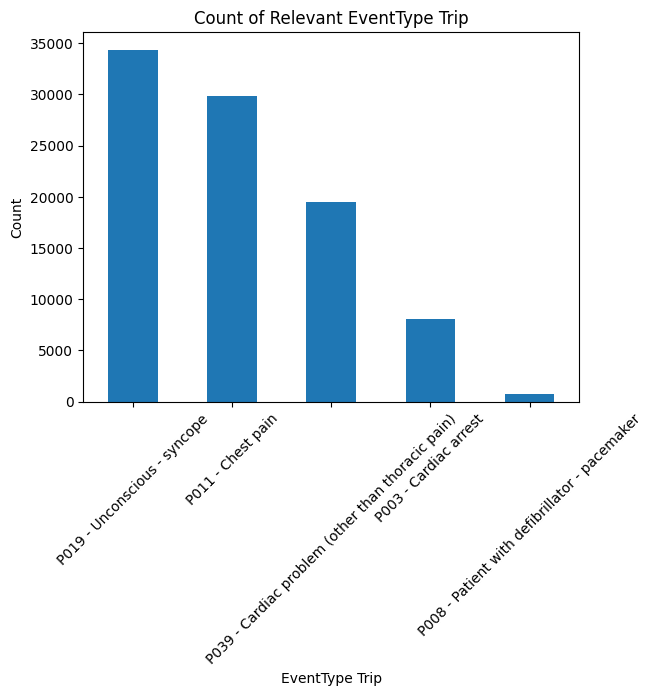

In [11]:
#visualize the relevent eventype trip : P003: CARDIAC ARREST,P039 CARDIAC PROBELM (other than thoracic pain),P008 - Patient with defibrillator - pacemaker,P011 - Chest pain,P019 - Unconscious - syncope 
# Filter for relevant event types only
relevant_event_types = ['P003 - Cardiac arrest','P039 - Cardiac problem (other than thoracic pain)','P008 - Patient with defibrillator - pacemaker','P011 - Chest pain','P019 - Unconscious - syncope']
interventions_filtered = interventions[interventions['EventType Trip'].isin(relevant_event_types)]

# Visualize the count of relevant event types
interventions_filtered['EventType Trip'].value_counts().plot(kind='bar')

plt.title('Count of Relevant EventType Trip')
plt.xlabel('EventType Trip')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.show()

In [12]:
cap_interventions = interventions[interventions['EventType Trip'] == 'P039 - Cardiac problem (other than thoracic pain)']

In [13]:
cap_interventions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19466 entries, 29 to 601829
Data columns (total 46 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Mission ID                        19466 non-null  int64  
 1   Service Name                      19463 non-null  object 
 2   PostalCode permanence             19358 non-null  float64
 3   CityName permanence               19357 non-null  object 
 4   StreetName permanence             19463 non-null  object 
 5   HouseNumber permanence            950 non-null    object 
 6   Latitude permanence               16329 non-null  float64
 7   Longitude permanence              19075 non-null  float64
 8   Permanence short name             19464 non-null  object 
 9   Permanence long name              19464 non-null  object 
 10  Vector type                       19466 non-null  object 
 11  EventType Firstcall               19465 non-null  object 
 12  EventLe

In [14]:
aed_interventions = interventions[interventions['EventType Trip'] == 'P008 - Patient with defibrillator - pacemaker']

In [15]:
aed_interventions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 753 entries, 483 to 598981
Data columns (total 46 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Mission ID                        753 non-null    int64  
 1   Service Name                      753 non-null    object 
 2   PostalCode permanence             750 non-null    float64
 3   CityName permanence               750 non-null    object 
 4   StreetName permanence             753 non-null    object 
 5   HouseNumber permanence            29 non-null     object 
 6   Latitude permanence               645 non-null    float64
 7   Longitude permanence              735 non-null    float64
 8   Permanence short name             753 non-null    object 
 9   Permanence long name              753 non-null    object 
 10  Vector type                       753 non-null    object 
 11  EventType Firstcall               753 non-null    object 
 12  EventLev

relevent eventype: 
P003: CARDIAC ARREST
p039 CARDIAC PROBELM (other than thoracic pain)
P008 - Patient with defibrillator - pacemaker

? 
P011 - Chest pain
P019 - Unconscious - syncope 

###### only cardiac arrest

In [16]:
# select cardiac arrest interventions:  6869 cardiac arrest interventions with location info 
ca_interventions = interventions[interventions['EventType Trip'] == 'P003 - Cardiac arrest']
ca_interventions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8097 entries, 42 to 601739
Data columns (total 46 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Mission ID                        8097 non-null   int64  
 1   Service Name                      8096 non-null   object 
 2   PostalCode permanence             8028 non-null   float64
 3   CityName permanence               8028 non-null   object 
 4   StreetName permanence             8096 non-null   object 
 5   HouseNumber permanence            292 non-null    object 
 6   Latitude permanence               6806 non-null   float64
 7   Longitude permanence              7968 non-null   float64
 8   Permanence short name             8096 non-null   object 
 9   Permanence long name              8096 non-null   object 
 10  Vector type                       8097 non-null   object 
 11  EventType Firstcall               8097 non-null   object 
 12  EventLev

<Axes: xlabel='Vector type'>

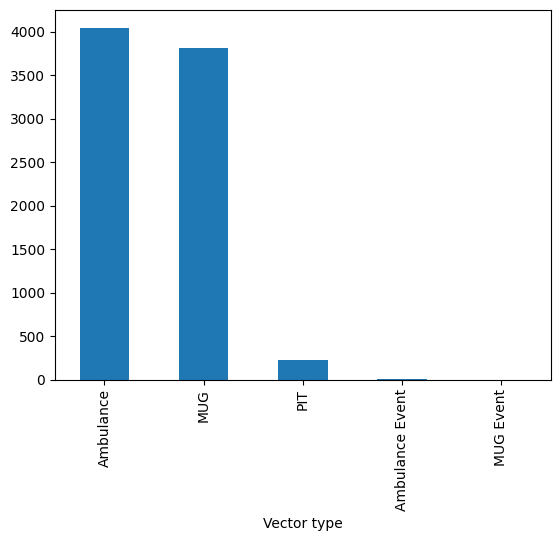

In [17]:
#visualize the data with cloumn vector type
ca_interventions['Vector type'].value_counts().plot(kind='bar')

In [18]:
#translate abondon reason to english
ca_interventions['Abandon reason'] = ca_interventions['Abandon reason'].map({'Overleden': 'Died',
    'Geannuleerd': 'Canceled',
    'Weigering van vervoer': 'Refusal of transport',
    'Zonder patient': 'Without patient',
    'Vervoerd door derden': 'Transported by third party',
    'Verzorgd ter plaatse': 'Treated on site',
    'Vervoerd door politie': 'Transported by police',
    'Kwaadwillig': 'Malicious'})                                             

C:\Users\feng\AppData\Local\Temp\ipykernel_14144\2922227703.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ca_interventions['Abandon reason'] = ca_interventions['Abandon reason'].map({'Overleden': 'Died',


In [19]:
# show both the abandon reason number and percentage
ca_interventions['Abandon reason'].value_counts()


Abandon reason
Died                          2817
Canceled                        92
Without patient                 28
Refusal of transport            28
Transported by third party      23
Treated on site                 14
Transported by police           10
Malicious                        3
Name: count, dtype: int64

In [20]:
#visualization
visual_df = ca_interventions.dropna(subset=['Latitude intervention', 'Longitude intervention','CityName intervention','Province intervention'])

In [21]:
# Create the map using Plotly Express
fig = px.scatter_mapbox(visual_df,
                        lat='Latitude intervention',
                        lon='Longitude intervention',
                        hover_name='CityName intervention',  # Customize as needed
                        color='Abandon reason',  # location(province/city) /vector type/abandon reason
                        zoom=7,
                        height=600,
                        mapbox_style='open-street-map')
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

Timestamps is crucial for analyzing response efficiency

the time intervals between T0-T1, T1-T3, and T3-T5 can be analyzed to find areas where the response time could be reduced, which is particularly important for improving outcomes in time-sensitive emergencies like cardiac arrests. The entire sequence can help identify bottlenecks and areas of improvement in the emergency response workflow.

Note on the timestamps:
T1/T1confirm -T0: call response time, 
T3-T1 on-scen time (T2-T1 vector prepare to go, T3-T2 time spent to the intervetion location), 
T5-T3 transport back time (T4-T3 care on site/move patient, T5-T4 time spent on the way to destination hospital)

T6,T7 (may not directly relevant to the survival of patient)

Intervention time (T1Reported)    
Intervention time (T1Confirmed)  
Waiting time                     
Intervention duration             
Departure time (T1Reported)      
Departure time (T1Confirmed)      

In [22]:
# subset the data
df = ca_interventions[['T0', 'T1', 'T1confirmed', 'T2', 'T3', 'T4',
       'T5', 'T6', 'T7', 'Intervention time (T1Reported)',
       'Intervention time (T1Confirmed)', 'Waiting time',
       'Intervention duration', 'Departure time (T1Reported)',
       'Departure time (T1Confirmed)', 'Abandon reason', 'Calculated travelTime destinatio',
       'Calculated Distance destination']]


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8097 entries, 42 to 601739
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   T0                                8097 non-null   object 
 1   T1                                8097 non-null   object 
 2   T1confirmed                       6521 non-null   object 
 3   T2                                6370 non-null   object 
 4   T3                                5889 non-null   object 
 5   T4                                1348 non-null   object 
 6   T5                                1214 non-null   object 
 7   T6                                5797 non-null   object 
 8   T7                                5855 non-null   object 
 9   Intervention time (T1Reported)    7062 non-null   float64
 10  Intervention time (T1Confirmed)   6889 non-null   float64
 11  Waiting time                      7062 non-null   float64
 12  Interven

lacks of T4,T5,calculated travelTime/distance data,
- use data including T4,T5   
  (around 1k, maybe only these cases drived to the hospital)

- focus on time spent on T0-T3 (response time, preparation and arrangement of vector, time spent on the way to intervention)
  (around 6k)

In [24]:
df.head()

,T0,T1,T1confirmed,T2,T3,T4,T5,T6,T7,Intervention time (T1Reported),Intervention time (T1Confirmed),Waiting time,Intervention duration,Departure time (T1Reported),Departure time (T1Confirmed),Abandon reason,Calculated travelTime destinatio,Calculated Distance destination
42,01JUN22:06:45:53,01JUN22:06:48:30,2022-06-01 06:48:48.168,2022-06-01 06:52:06.354,2022-06-01 07:04:46.095,None,None,2022-06-01 06:49:27.997,None,16.0,16.0,19.0,4.0,4.0,4.0,NaN,NaN,NaN
87,01JUN22:09:28:15,01JUN22:09:29:42,2022-06-01 09:29:45.722,2022-06-01 09:30:28.285,2022-06-01 09:32:29.322,None,None,2022-06-01 09:59:48.808,None,3.0,3.0,4.0,31.0,1.0,1.0,Died,NaN,NaN
88,01JUN22:09:28:15,01JUN22:09:29:44,2022-06-01 09:29:48.347,2022-06-01 09:35:10.792,2022-06-01 09:40:51.753,None,None,2022-06-01 10:04:58.155,2022-06-01 10:12:54.228,11.0,11.0,12.0,36.0,6.0,6.0,NaN,NaN,NaN
207,01JUN22:15:11:15,01JUN22:15:12:22,2022-06-01 15:12:54.583,2022-06-01 15:14:47.332,2022-06-01 15:24:40.674,None,None,2022-06-01 15:43:14.371,2022-06-01 16:03:41.786,12.0,12.0,13.0,32.0,2.0,2.0,NaN,NaN,NaN
208,01JUN22:15:11:15,01JUN22:15:12:22,2022-06-01 15:13:42.393,2022-06-01 15:17:56.103,2022-06-01 15:47:52.170,None,None,2022-06-01 15:47:55.123,2022-06-01 16:02:21.883,35.0,34.0,36.0,36.0,5.0,4.0,Died,NaN,NaN


In [25]:
# List of columns to calculate differences between
time_cols = ['T0', 'T1', 'T1confirmed', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7']

# Correct the time formats for T0 and T1
df['T0'] = pd.to_datetime(df['T0'], format='%d%b%y:%H:%M:%S', errors='coerce')
df['T1'] = pd.to_datetime(df['T1'], format='%d%b%y:%H:%M:%S', errors='coerce')

# Convert the rest of the timestamps to datetime
for col in ['T1confirmed', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7']:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Calculate the time intervals in seconds
for i in range(len(time_cols) - 1):
    col1, col2 = time_cols[i], time_cols[i+1]
    df[f'{col2}-{col1}'] = (df[col2] - df[col1]).dt.total_seconds().round(1)
    # Set the value to None where either timestamp is missing
    df[f'{col2}-{col1}'] = df[f'{col2}-{col1}'].where(df[col1].notna() & df[col2].notna(), None)


C:\Users\feng\AppData\Local\Temp\ipykernel_14144\3393133967.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\feng\AppData\Local\Temp\ipykernel_14144\3393133967.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\feng\AppData\Local\Temp\ipykernel_14144\3393133967.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8097 entries, 42 to 601739
Data columns (total 26 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   T0                                8097 non-null   datetime64[ns]
 1   T1                                8097 non-null   datetime64[ns]
 2   T1confirmed                       6521 non-null   datetime64[ns]
 3   T2                                6370 non-null   datetime64[ns]
 4   T3                                5889 non-null   datetime64[ns]
 5   T4                                1348 non-null   datetime64[ns]
 6   T5                                1214 non-null   datetime64[ns]
 7   T6                                5797 non-null   datetime64[ns]
 8   T7                                5855 non-null   datetime64[ns]
 9   Intervention time (T1Reported)    7062 non-null   float64       
 10  Intervention time (T1Confirmed)   6889 non-null   

In [29]:
# Ensure T0 and T3 are in datetime format, converting if necessary
df['T0'] = pd.to_datetime(df['T0'], format='%d%b%y:%H:%M:%S', errors='coerce')
df['T3'] = pd.to_datetime(df['T3'], errors='coerce')

# Calculate the time intervals between T0 and T3 in seconds, rounding to one decimal place
df['T3-T0'] = (df['T3'] - df['T0']).dt.total_seconds().round(1)

# Display the updated DataFrame or the specific column to verify the calculation
df['T3-T0']


C:\Users\feng\AppData\Local\Temp\ipykernel_14144\2810953688.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\feng\AppData\Local\Temp\ipykernel_14144\2810953688.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\feng\AppData\Local\Temp\ipykernel_14144\2810953688.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

42        1133.1
87         254.3
88         756.8
207        805.7
208       2197.2
           ...  
601368       NaN
601489       NaN
601728       NaN
601729       NaN
601739       NaN
Name: T3-T0, Length: 8097, dtype: float64

In [31]:
df['T3-T0'].head()

42     1133.1
87      254.3
88      756.8
207     805.7
208    2197.2
Name: T3-T0, dtype: float64

In [33]:
df['Waiting time'].head()*60

42     1140.0
87      240.0
88      720.0
207     780.0
208    2160.0
Name: Waiting time, dtype: float64

In [90]:
df.to_csv('Data/interventions_timestamps.csv', index=False)

##### interventions bxls

In [14]:
# Combine the datasets
interventions_bxls = pd.concat([interventions_bxl, interventions_bxl2], ignore_index=True)


In [16]:
interventions_bxls.columns

Index(['mission_id', 'service_name', 'postalcode_permanence',
       'cityname_permanence', 'streetname_permanence',
       'housenumber_permanence', 'latitude_permanence', 'longitude_permanence',
       'permanence_short_name', 'permanence_long_name', 'vector_type',
       'eventtype_firstcall', 'eventLevel_firstcall', 'eventtype_trip',
       'eventlevel_trip', 'postalcode_intervention', 'cityname_intervention',
       'latitude_intervention', 'longitude_intervention', 't0', 't1',
       't1confirmed', 't2', 't3', 't4', 't5', 't6', 't7', 't9',
       'intervention_time_t1reported', 'waiting_time', 'intervention_duration',
       'departure_time_t1reported', 'unavailable_time',
       'name_destination_hospital', 'postalcode_destination_hospital',
       'cityname_destination_hospital', 'streetname_destination_hospital',
       'housenumber_destination_hospital', 'calculated_traveltime_departure_',
       'calculated_distance_departure_to', 'calculated_traveltime_destinatio',
       '

In [22]:
df2 = interventions_bxls.dropna(subset=['Latitude intervention', 'Longitude intervention'])

In [ ]:
# Create the map using Plotly Express
fig = px.scatter_mapbox(df2,
                        lat='Latitude intervention',
                        lon='Longitude intervention',
                        hover_name='vector_type',  # Customize as needed
                        color='eventlevel_trip',  # Customize as needed
                        zoom=7,
                        height=600,
                        mapbox_style='open-street-map')
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

##### mug - source

MUG (Mobile Urgency Group): Specialized emergency medical teams, often equipped to provide advanced pre-hospital care in critical situations.

In [12]:
mug_locations.info()
mug_locations.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   hospital_id     94 non-null     int64 
 1   mug_id          94 non-null     int64 
 2   campus_id       94 non-null     int64 
 3   name_hospital   94 non-null     object
 4   name_campus     59 non-null     object
 5   address_campus  94 non-null     object
 6   postal_code     94 non-null     int64 
 7   municipality    94 non-null     object
 8   region          94 non-null     object
 9   province        94 non-null     object
dtypes: int64(4), object(6)
memory usage: 7.5+ KB


,hospital_id,mug_id,campus_id,name_hospital,name_campus,address_campus,postal_code,municipality,region,province
0,9,102000,6230,ZIEKENHUISNETWERK ANTWERPEN (ZNA),ZNA CADIX,KEMPENSTRAAT 100,2030,ANTWERPEN,V,Antwerpen
1,99,102000,2020,GZA- ZIEKENHUIZEN,SINT-VINCENTIUS,ST.-VINCENTIUSSTRAAT 20,2018,ANTWERPEN,V,Antwerpen
2,682,102000,1210,AZ MONICA,DEURNE,FLORENT PAUWELSLEI 1,2100,DEURNE,V,Antwerpen
3,9,103000,2000,ZIEKENHUISNETWERK ANTWERPEN (ZNA),ZNA MIDDELHEIM,LINDENDREEF 1,2020,ANTWERPEN,V,Antwerpen
4,99,103000,1290,GZA- ZIEKENHUIZEN,SINT- AUGUSTINUS,OOSTERVELDLAAN 24,2610,WILRIJK,V,Antwerpen


##### pit - source

PIT (Paramedical Intervention Team): Teams that provide paramedical support and can include a variety of healthcare professionals, offering services that may not require the full resources of a MUG team.

In [27]:
pit_locations.info()
pit_locations.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   unit          24 non-null     object
 1   campus        24 non-null     object
 2   province      21 non-null     object
 3   region        24 non-null     object
 4   unit_id       24 non-null     object
 5   ambucode      24 non-null     int64 
 6   ambusitecode  24 non-null     int64 
 7   link          2 non-null      object
dtypes: int64(2), object(6)
memory usage: 1.6+ KB


,unit,campus,province,region,unit_id,ambucode,ambusitecode,link
0,"100001: PIT Rumst, AZ Rivierland",Ziekenhuis/Hôpital: 104 - AZ RIVIERENLAND --- ...,Antwerpen/Anvers,Vlaanderen/Flandre,PARUMS01A,191,19101,None
1,"102001: PIT Deinze, St Vincentius",Ziekenhuis/Hôpital: 134 - AZ SINT-VINCENTIUS -...,Oost-Vlaanderen/Flandre orientale,Vlaanderen/Flandre,PODEIN01A,413,41301,None
2,102101: PIT Stuivenberg,Ziekenhuis/Hôpital: 009 - ZIEKENHUISNETWERK AN...,Antwerpen/Anvers,Vlaanderen/Flandre,PAANTW01A,117,11704,None
3,"110001: PIT Lier, Heilig Hart",Ziekenhuis/Hôpital: 097 - HEILIG HART ZIEKENHU...,Antwerpen/Anvers,Vlaanderen/Flandre,PALIER01A,171,17101,None
4,113001: PIT HEILIG HART ZIEKENHUIS,Ziekenhuis/Hôpital: 102 - HEILIG HART ZIEKENHU...,Antwerpen/Anvers,Vlaanderen/Flandre,PAMOL_01A,190,19001,None
